# Testing Different ML Algorithms
Just getting an idea for what would be effective with this dataset

In [1]:
%matplotlib inline
from copy import deepcopy
from glob import glob
from matplotlib import pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import cross_validate, cross_val_predict, RepeatedKFold, GridSearchCV
from sklearn.linear_model import BayesianRidge, ARDRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from stopping_power_ml.io import load_qbox_data
import pandas as pd
import numpy as np
import pickle as pkl

In [2]:
import warnings; warnings.simplefilter('ignore')

## Load in the Dataset
This was created by a different notebook

In [3]:
data = pd.read_csv('training_set.csv')
print('Training set size:', len(data))

Training set size: 9449


Determine which columns are inputs

In [4]:
charge_attrs = [x for x in data.columns if x.startswith('density')]

In [5]:
agni_attrs = [x for x in data.columns if x.startswith('AGNI')]

In [6]:
ewald_attrs = ['ion-ion repulsion',]

In [7]:
y_col = 'force'

In [8]:
X_cols = charge_attrs + agni_attrs + ewald_attrs

## Test out Some ML Models
Trying out various differentiable ML algorithms:

- `DummyRegressor`: 
- `BayesianRidge`: Ridge regression that sets the hyperparameters for you
- ~~`ARDRegression`: Sparser BayesianRidge~~ [Too slow]
- `MLPRegressor`: Simple NN, annoying to tune
- ~~`GuassianProcessRegressor`: Nonlinear continuous model~~ [Too slow]
- `Lasso`: Sparse linear model, fast to train

### Create Testing Routines
Some tools used to test this model

In [9]:
kfold = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1) # 10x10-fold CV

In [10]:
def train_over_time(model, data, steps=None):
    """Train the model on increasingly-larger amounts of data
    
    :param model: model to be tested
    :param data: training/test data
    :param steps: increments to test at. Model is trained at all entries before this timestep
    :return: 
        - train_size: Number of training points
        - average_force: Average force (i.e., stopping power) as at each step
        - trajectory: Full trajectory
        - step: timestep
    """
    
    # Get the default steps
    if steps is None:
        steps = np.linspace(data['timestep'].min(), data['timestep'].max(), 31, dtype=np.int)[1:]
        
    # Test the models
    mean_forces = []
    trajs = []
    force_errors = []
    train_size = []
    for step in steps:
        # Train model on all timesteps before current
        train_data = data.query('timestep <= %d'%step)
        train_size.append(len(train_data))
        model.fit(train_data[X_cols], train_data[y_col])
        
        
        # Predict on all timesteps
        traj = model.predict(data[X_cols])
        
        # Store results
        mean_forces.append(traj.mean())
        trajs.append(traj)
        force_errors.append((traj - data[y_col]).mean())
    
    return train_size, mean_forces, trajs, steps

In [11]:
test_results = dict()
def run_tests(model, name, verbose=False):
    """Evaluate a model, store results in test_results variable
    
    :param model: model to test
    :param name: name of results to store"""
    
    # Standard cross-validation
    k_fold = cross_validate(model, data[charge_attrs+agni_attrs+ewald_attrs].values, data[y_col].values,
               scoring='neg_mean_squared_error', cv=kfold)
    if verbose:
        print('Model: %s - K-fold error: mean=%.2e max=%.2e'%(name, -k_fold['test_score'].mean(), -k_fold['test_score'].min()))
        
    # Increase time CV
    step, mean_forces, traj, steps = train_over_time(model, data)
    
    if verbose:
        print('Model: %s - Stopping power after half simulation: predicted=%.2f actual=%.2f'%(name,
                                                                                              mean_forces[int(len(mean_forces)/2)],
                                                                                             data[y_col].mean()))
        
    # Train model on whole dataset
    model.fit(data[charge_attrs+agni_attrs+ewald_attrs].values, data[y_col].values)
    
    test_results[name] = {
        'k_fold':k_fold,
        'over_time': {'training_size': step, 'mean_force': mean_forces, 'traj': traj, 'step':steps},
        'model': deepcopy(model)
    }

### Run a dummy model
Get a "non-ML" baseline

In [12]:
model = DummyRegressor()

In [13]:
%%time
run_tests(model, 'dummy', True)

Model: dummy - K-fold error: mean=2.25e+01 max=5.38e+01
Model: dummy - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 120 ms, sys: 10.1 ms, total: 130 ms
Wall time: 129 ms


### Test default NN
Get a baseline for the later tuning

In [14]:
model = MLPRegressor(activation='tanh', hidden_layer_sizes=(16,))

In [15]:
model

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(16,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [16]:
%%time
run_tests(model, 'baseline_nn', True)

Model: baseline_nn - K-fold error: mean=1.59e-01 max=4.74e-01
Model: baseline_nn - Stopping power after half simulation: predicted=0.25 actual=0.24
CPU times: user 9min 12s, sys: 16 s, total: 9min 28s
Wall time: 1min 30s


### Test Bayesian Ridge


In [17]:
model = BayesianRidge(normalize=True)

In [18]:
%%time
run_tests(model, 'bayes', True)

Model: bayes - K-fold error: mean=2.16e-03 max=2.47e-03
Model: bayes - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 3.14 s, sys: 147 ms, total: 3.29 s
Wall time: 339 ms


#### Measure Feature Importances

In [19]:
model.fit(data[X_cols], data[y_col])

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=True, tol=0.001, verbose=False)

In [20]:
pd.DataFrame({'feature':X_cols, 'weight':model.coef_})

,feature,weight
0,density t=-1.000000,-0.037006
1,density t=-2.000000,-0.002881
2,density t=-3.000000,0.030122
3,density t=-4.000000,0.015651
4,density t=-5.000000,0.013172
5,density t=0.000000,-0.016046
6,density t=1.000000,0.007187
7,AGNI eta=1.04e+01,8012.755852
8,AGNI eta=1.23e+00,43.073962
9,AGNI eta=1.60e+01,-3793.554066


### Test Bayesian Ridge w/ Poly Features

In [21]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('model', BayesianRidge())
])

In [22]:
%%time
run_tests(model, 'bayes_poly', True)

Model: bayes_poly - K-fold error: mean=1.44e-04 max=1.68e-04
Model: bayes_poly - Stopping power after half simulation: predicted=0.26 actual=0.24
CPU times: user 58.9 s, sys: 1.71 s, total: 1min
Wall time: 6.1 s


### Lasso

In [23]:
model = GridSearchCV(Lasso(normalize=True, max_iter=5000, fit_intercept=True), {'alpha':np.logspace(-7,-1,20)}, cv=2)

In [24]:
%%time
run_tests(model, 'lasso', True)

Model: lasso - K-fold error: mean=9.17e-03 max=1.29e-02
Model: lasso - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 14min 20s, sys: 20.4 s, total: 14min 40s
Wall time: 2min 9s


#### Measure Feature Importances

In [25]:
model.fit(data[X_cols], data[y_col])

GridSearchCV(cv=2, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-07,   2.06914e-07,   4.28133e-07,   8.85867e-07,
         1.83298e-06,   3.79269e-06,   7.84760e-06,   1.62378e-05,
         3.35982e-05,   6.95193e-05,   1.43845e-04,   2.97635e-04,
         6.15848e-04,   1.27427e-03,   2.63665e-03,   5.45559e-03,
         1.12884e-02,   2.33572e-02,   4.83293e-02,   1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [26]:
model.best_estimator_.alpha

3.3598182862837813e-05

In [27]:
pd.DataFrame({'feature':X_cols, 'weight':model.best_estimator_.coef_})

,feature,weight
0,density t=-1.000000,0.036338
1,density t=-2.000000,-0.022177
2,density t=-3.000000,0.031001
3,density t=-4.000000,0.014495
4,density t=-5.000000,0.000000
5,density t=0.000000,-0.006832
6,density t=1.000000,-0.066837
7,AGNI eta=1.04e+01,0.000000
8,AGNI eta=1.23e+00,10.138283
9,AGNI eta=1.60e+01,0.000000


*Finding*: Charge density is not important. Also, AGNI fingerprints do not carry velocity information

## Plot the Results

Mean absolute error of the force averaged across the entire trajectory

In [28]:
experiment_number = 14

print('Training set size: ', test_results['dummy']['over_time']['training_size'][experiment_number])
results = dict([
    (name, {'force_mae': np.abs(data[y_col] - my_data['over_time']['traj'][experiment_number]).mean(),
            'mean_force_error': data[y_col].mean() - my_data['over_time']['mean_force'][experiment_number]})
    for name, my_data in test_results.items()
])
over_time_results = pd.DataFrame(results).T
over_time_results

Training set size:  4725


,force_mae,mean_force_error
baseline_nn,0.160803,-0.017317
bayes,0.034764,0.002897
bayes_poly,0.065740,-0.019941
dummy,0.715687,0.001903
lasso,0.047276,0.002371


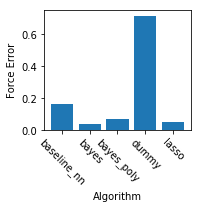

In [29]:
fig, ax = plt.subplots()

ax.bar(range(len(over_time_results)), over_time_results['force_mae'])

ax.set_xticks(range(len(over_time_results)))
ax.set_xticklabels(list(over_time_results.index), fontsize=10, rotation=-45);

ax.set_ylabel('Force Error')
ax.set_xlabel('Algorithm', fontsize=10)

fig.set_size_inches(2.9, 3)
fig.tight_layout()

fig.savefig('figures/ml_algorithm_error.pdf')
fig.savefig('figures/ml_algorithm_error.png', dpi=320)

Stopping power as a function of training set size. Black line is the known average

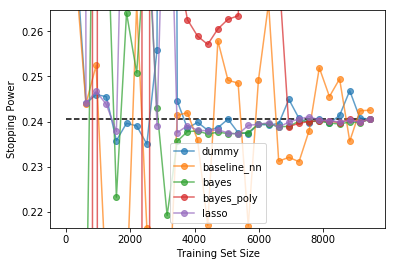

In [30]:
fig, ax = plt.subplots()

ax.plot([0,data['timestep'].max() - data['timestep'].min()], [data['force'].mean(),]*2, 'k--')

for name, my_data in test_results.items():
    ax.plot(my_data['over_time']['training_size'], my_data['over_time']['mean_force'], marker='o', label=name, alpha=0.7)
    
ax.set_ylim(data['force'].mean() * 0.9, data['force'].mean() * 1.1)

ax.legend()

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Stopping Power')

*Finding*: Bayesian linear regression seems to work the best

*To Do*: 
- Get Bayesian linear regression confidence intervals
- Incorporate velocity-dependent attributes. Only charge density is dependent
    - Or, switch to use recurrant models
- Figure out scaling on ARDRegression (want Lasso with confidence intervals)

## Plot just the best one: BayesRidge

In [31]:
def scale_force(x, exag=3):
    return np.sign(x) * np.power(np.abs(x), 1./exag) 
def unscale_force(x, exag=3):
    return np.sign(x) * np.abs(np.power(x, exag))

In [32]:
best_results = test_results['bayes']
num_tests = len(best_results['over_time']['traj'])

Plot the convergence of the stopping power

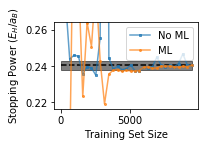

In [33]:
fig, ax = plt.subplots()

ax.plot([0,data['timestep'].max() - data['timestep'].min()], [data['force'].mean(),]*2, 'k--')#, label='Known Value')

ax.fill_between([0, data['timestep'].max() - data['timestep'].min()],
                [data['force'].mean() * 1.01, data['force'].mean() * 1.01],
                [data['force'].mean() * 0.99, data['force'].mean() * 0.99], color='k', alpha=0.5)

ax.plot(test_results['dummy']['over_time']['training_size'],
        test_results['dummy']['over_time']['mean_force'], marker='s', ms=2, alpha=0.7, label='No ML')
ax.plot(best_results['over_time']['training_size'], best_results['over_time']['mean_force'], 
        marker='o', ms=2, alpha=0.7, label='ML')
    
ax.set_ylim(data['force'].mean() * 0.9, data['force'].mean() * 1.1)

ax.legend()

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Stopping Power ($E_H/a_B$)')

fig.set_size_inches(3, 2)

fig.tight_layout()
fig.savefig('figures/stopping_power_bayes.pdf')
fig.savefig('figures/stopping_power_bayes.png', dpi=320)

Plot the force error as a function of training set size

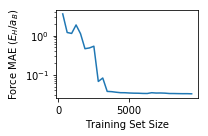

In [34]:
fig, ax = plt.subplots()


mae = [ np.abs(data['force'] - t).mean() for t in best_results['over_time']['traj'] ] 

ax.semilogy(best_results['over_time']['training_size'], mae)
    
    
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Force MAE ($E_H/a_B$)')

fig.set_size_inches(3, 2)

fig.tight_layout()
fig.savefig('figures/mae_training_size.pdf')
fig.savefig('figures/mae_training_size.png', dpi=320)

Plot how well the algorithm forecasts stopping force

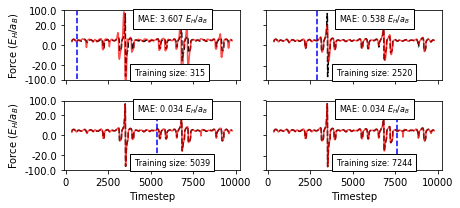

In [35]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)


for f,ax in zip([0,int(0.25*num_tests),int(0.5*num_tests),int(0.75*num_tests)],axs.flatten()):
    
    ax.plot(data['timestep'], scale_force(data['force']), 'k--')
    ax.set_ylim(ax.get_ylim()) # Make sure the scales stay appropriate
    
    traj = best_results['over_time']['traj'][f]
    ax.plot(data['timestep'], scale_force(traj), 'r-', alpha=0.7)
    traj_error = np.abs(traj - data['force']).mean()
    
    ax.text(4200, scale_force(30), 'MAE: %.3f $E_H/a_B$'%traj_error, fontsize=8,
           bbox=dict(edgecolor='k', facecolor='w'))
    
    ax.text(4000, -4, 'Training size: %d'%best_results['over_time']['training_size'][f],
            fontsize=8,
           bbox=dict(edgecolor='k', facecolor='w'))
    
    ax.plot([best_results['over_time']['step'][f],]*2, ax.get_ylim(), 'b--')

axs[1,0].set_xlabel('Timestep')
axs[1,1].set_xlabel('Timestep')
axs[0,0].set_ylabel('Force ($E_H/a_B$)')
axs[1,0].set_ylabel('Force ($E_H/a_B$)')

# Unscale force
y_ticks = [-100, -20, 0, 20, 100]
axs[0,0].set_yticks(scale_force(y_ticks))
axs[0,0].set_yticklabels(['%.1f'%f for f in y_ticks])
axs[1,0].set_yticks(scale_force(y_ticks))
axs[1,0].set_yticklabels(['%.1f'%f for f in y_ticks])

fig.set_size_inches(6.5,3)
fig.tight_layout()
fig.savefig('figures/ml_over_time.pdf')
fig.savefig('figures/ml_over_time.png', dpi=320)

## Compute Stopping Power on Different Path
Read in the files from another Al trajectory. `Al_256_channel` is a simulation at the same velocity as what we have trained this model on, but along a different path in the crystal.

Read in the data

In [36]:
%%time
new_data = []
for file in glob('Al_256_channel/kpg*.out'):
    frame = load_qbox_data(file)
    frame['file'] = file
    new_data.append(frame)
new_data = pd.concat(new_data)
print('Read in %d training points'%len(new_data))

Read in 2000 training points
CPU times: user 1min 5s, sys: 500 ms, total: 1min 5s
Wall time: 1min 5s


In [37]:
new_data.sort_values(['file_id', 'frame_id'], ascending=True, inplace=True)
new_data['timestep'] = list(range(len(new_data)))
new_data.set_index('timestep', inplace=True, drop=False)
new_data['displacement'] = (new_data['position'] - new_data['position'][0]).apply(np.linalg.norm)

Read in the feature calculators

In [38]:
featurizers = pkl.load(open('featurizers.pkl', 'rb'))

In [39]:
%%time
for f in featurizers:
    new_data = f.featurize_dataframe(new_data, 'atoms', n_jobs=None)

CPU times: user 1.92 s, sys: 1.39 s, total: 3.31 s
Wall time: 2min 30s


Compute the lattice spacing

In [40]:
lat_spacing = new_data['atoms'][0].cell[0,0] / 4

Plot the results

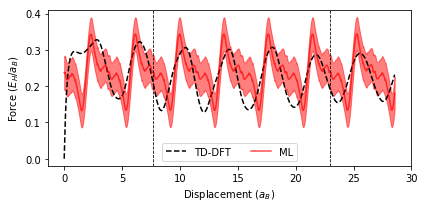

In [41]:
fig, ax = plt.subplots()

# Plot the true result
ax.plot(new_data['displacement'], new_data['force'], 'k--', label='TD-DFT')

# Plot the ML predictions
fmean, fstd = best_results['model'].predict(new_data[X_cols], True)
ax.fill_between(new_data['displacement'], fmean + fstd, fmean - fstd, color='r', alpha=0.5)
ax.plot(new_data['displacement'], fmean, 'r-', alpha=0.7, label='ML')

# Plot the sample range
ax.set_ylim(ax.get_ylim())

ax.plot([lat_spacing,] * 2, ax.get_ylim(), 'k--', lw=0.8)
ax.plot([lat_spacing * 3,] * 2, ax.get_ylim(), 'k--', lw=0.8)

ax.legend(ncol=2)

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force ($E_H / a_B$)')

fig.set_size_inches(6, 3)
fig.tight_layout()

fig.savefig('figures/stopping_power_Al[001]-trajectory.png', dpi=320)
fig.savefig('figures/stopping_power_Al[001]-trajectory.pdf')

Compute the stopping power with each ML algorithm

In [42]:
new_data_subset = data.query('displacement >= %f and displacement <= %f'%(lat_spacing, lat_spacing * 3))

actual_stopping_power = new_data_subset['force'].mean()

names = []
stopping_powers = []
for k,d in test_results.items():
    names.append(k)
    stopping_powers.append(np.mean(d['model'].predict(new_data_subset[X_cols])))
    
errors = [(x - actual_stopping_power) / actual_stopping_power for x in stopping_powers]

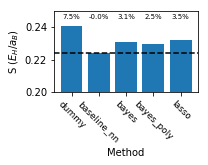

In [43]:
fig, ax = plt.subplots()

# Plot the ML results
ax.bar(list(range(len(names))), stopping_powers)
ax.set_xticks(list(range(len(names))))
ax.set_xticklabels(names, fontsize=9, rotation=-45);

for i,e in enumerate(errors):
    ax.text(i, 0.245, '%.1f%%'%(e* 100), ha='center', fontsize=7)#, bbox={'facecolor': 'w', 'edgecolor': 'w'})

# Plot the actual result
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [actual_stopping_power,] * 2, 'k--')

# Make it pretty
ax.set_ylim(0.2, 0.25)

ax.set_xlabel('Method')
ax.set_ylabel('S ($E_H / a_B$)')

fig.set_size_inches(3, 2.4)
fig.tight_layout()
fig.savefig('figures/stopping_power_Al[001].png', dpi=320)
fig.savefig('figures/stopping_power_Al[001].pdf', dpi=320)
